# Case Study 1: Habitat Suitability and Potential Distribution Modeling of Fairy Pitta (Pitta nympha) Using Presence-Only Data

In [1]:
import eeSDM
import ee, geemap
import geemap.colormaps as cm

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import random, math, os

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Earth Engine Authentication
# ee.Authenticate()

# Initializing Earth Engine
ee.Initialize()

## 1. Add Species Occurrence Data

In [3]:
# Load GBIF GeoPackage
input_gpkg_file = 'https://osgeokr.github.io/pySDM-geemap/pitta_nympha_data.gpkg'
gdf = gpd.read_file(input_gpkg_file)[["species", "year", "month", "eventDate", "geometry"]]
gdf.head(1)

,species,year,month,eventDate,geometry
0,Pitta nympha,2023,5,2023-05-27T13:33:36,POINT (126.72514 33.20314)


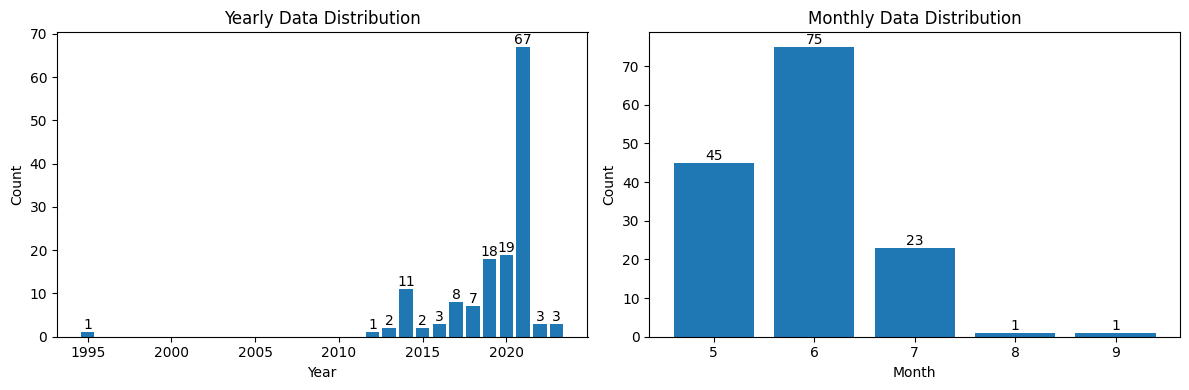

In [4]:
# Plot Yearly & Monthly data distribution
eeSDM.plot_data_distribution(gdf)

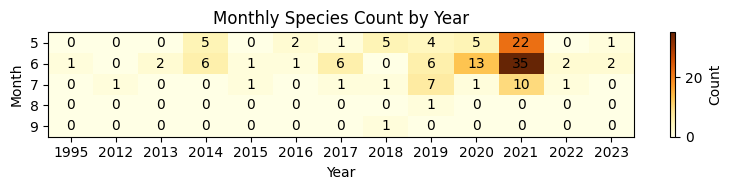

year   1995  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  \
month                                                                           
5         0     0     0     5     0     2     1     5     4     5    22     0   
6         1     0     2     6     1     1     6     0     6    13    35     2   
7         0     1     0     0     1     0     1     1     7     1    10     1   
8         0     0     0     0     0     0     0     0     1     0     0     0   
9         0     0     0     0     0     0     0     1     0     0     0     0   

year   2023  
month        
5         1  
6         2  
7         0  
8         0  
9         0  


In [5]:
# Plot heatmap
eeSDM.plot_heatmap(gdf)

In [6]:
# Add presence-only raw data
gdf.to_file("pitta_nympha_data.shp")
data_raw = geemap.shp_to_ee("pitta_nympha_data.shp")

# Set spatial resolution (meters)
GrainSize = 1000

# Apply the function to the raw data with the specified GrainSize
Data = eeSDM.remove_duplicates(data_raw, GrainSize)

print('Original data size:', data_raw.size().getInfo())
print('Final data size:', Data.size().getInfo())

Original data size: 145
Final data size: 97


## 2. Define Area of Interest (AOI)

In [7]:
# Define Area of Interest (AOI)
# Calculate the bounding box of the Data and expand it by 50,000 meters
AOI = Data.geometry().bounds().buffer(distance=50000, maxError=1000)

# Create an outline image of the AOI for visualization
outline = ee.Image().byte().paint(featureCollection=AOI, color=1, width=3)

# Creating an Empty geemap Map Object
Map = geemap.Map()

Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.addLayer(data_raw, {'color': 'blue'}, 'Original data')
Map.addLayer(Data, {'color': 'red'}, 'Final data')
Map.centerObject(Data.geometry(), 6)
Map

Map(center=[35.4867782563472, 126.8854400655101], controls=(WidgetControl(options=['position', 'transparent_bg…

## 3. Add Predictive Variables

In [8]:
# WorldClim BIO Variables V1 (1km): A total of 19 climate variables
BIO = ee.Image("WORLDCLIM/V1/BIO")

# NASA SRTM Digital Elevation 30m: Digital elevation data
Terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))

# MOD44B.006 Terra MODIS Vegetation Continuous Fields Yearly Global 250m
# Percent Tree Cover: Median between 2003 and 2020
MODIS = ee.ImageCollection("MODIS/006/MOD44B")
MedianPTC = MODIS.filterDate('2003-01-01', '2020-12-31').select(['Percent_Tree_Cover'], ['PTC']).median()

# Combining Bands into a Single Multi-Band Image
predictors = BIO.addBands(Terrain).addBands(MedianPTC)

# Masking Ocean Pixels & Clipping to the Area of Interest
predictors = predictors.updateMask(ee.Image("USGS/SRTMGL1_003").gt(0)).clip(AOI)

In [9]:
# Extracting Covariate Values between Multi-Band Predictive Images at 5000 Random Locations
DataCor = predictors.sample(scale=GrainSize, numPixels=5000, geometries=True) # Generating 5000 Random Locations
PixelVals = predictors.sampleRegions(collection=DataCor, scale=GrainSize, tileScale=16) # Extracting Covariate Values

# Converting Covariate Values from ee to DataFrame
PixelVals_df = geemap.ee_to_pandas(PixelVals)
PixelVals_df.head(1)

,elevation,bio08,bio19,bio09,slope,bio10,hillshade,aspect,bio06,bio17,...,bio05,bio16,bio02,bio13,bio03,bio14,bio11,PTC,bio01,bio12
0,31,247,112,27,0,247,181,296,-27,112,...,304,563,89,218,26,33,27,7.0,139,1162


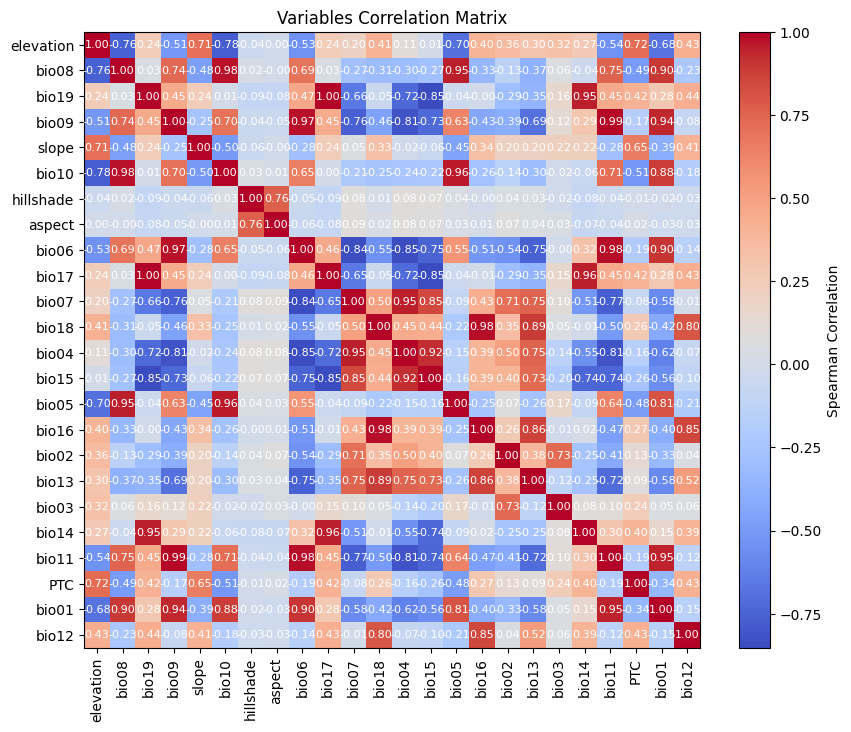

In [10]:
# Plot correlation heatmap
eeSDM.plot_correlation_heatmap(PixelVals_df)

In [11]:
# Perform filtering using VIF (Variance Inflation Factor)
# Apply the function to remove variables with high multicollinearity
# Obtain the list of remaining column names after VIF-based filtering
filtered_PixelVals_df, bands = eeSDM.filter_variables_by_vif(PixelVals_df)

Removing 'bio06' with VIF inf
Removing 'bio04' with VIF 213143.75
Removing 'bio10' with VIF 68437.04
Removing 'bio17' with VIF 48555.55
Removing 'bio05' with VIF 32374.85
Removing 'bio07' with VIF 22348.86
Removing 'bio01' with VIF 9725.41
Removing 'bio16' with VIF 3785.62
Removing 'bio03' with VIF 2515.02
Removing 'bio18' with VIF 1791.83
Removing 'bio08' with VIF 1383.23
Removing 'bio12' with VIF 618.77
Removing 'bio19' with VIF 488.40
Removing 'bio15' with VIF 340.60
Removing 'hillshade' with VIF 120.15
Removing 'bio13' with VIF 49.94
Removing 'bio11' with VIF 35.68
Removing 'bio02' with VIF 15.55
Bands: ['elevation', 'bio09', 'slope', 'aspect', 'bio14', 'PTC']


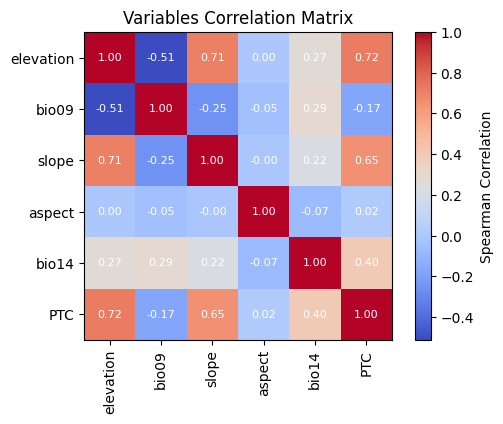

In [12]:
# Select only the bands (predictor variables) that remain after filtering
predictors = predictors.select(bands)

# Plot correlation heatmap
eeSDM.plot_correlation_heatmap(filtered_PixelVals_df, h_size=6)

In [13]:
# elevation
Map = geemap.Map()
vis_params = {'bands':['elevation'], 'min': 0, 'max': 1800, 'palette': cm.palettes.terrain}
Map.addLayer(predictors, vis_params, 'elevation')
Map.add_colorbar(vis_params, label="Elevation (m)", orientation="vertical", layer_name="elevation")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.4867782563472, 126.8854400655101], controls=(WidgetControl(options=['position', 'transparent_bg…

In [14]:
# Minimum and Maximum Values of bio09
min_val = predictors.select("bio09").multiply(0.1).reduceRegion(reducer=ee.Reducer.min(), scale=1000).getInfo()
max_val = predictors.select("bio09").multiply(0.1).reduceRegion(reducer=ee.Reducer.max(), scale=1000).getInfo()

# bio09
Map = geemap.Map()
vis_params = {'min': math.floor(min_val['bio09']), 'max': math.ceil(max_val['bio09']), 'palette': cm.palettes.hot}
Map.addLayer(predictors.select("bio09").multiply(0.1), vis_params, 'bio09')
Map.add_colorbar(vis_params, label="Mean temperature of driest quarter (℃)", orientation="vertical", layer_name="bio09")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.4867782563472, 126.8854400655101], controls=(WidgetControl(options=['position', 'transparent_bg…

In [15]:
# slope
Map = geemap.Map()
vis_params = {'bands':['slope'], 'min': 0, 'max': 25, 'palette': cm.palettes.RdYlGn_r}
Map.addLayer(predictors, vis_params, 'slope')
Map.add_colorbar(vis_params, label="Slope", orientation="vertical", layer_name="slope")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.4867782563472, 126.8854400655101], controls=(WidgetControl(options=['position', 'transparent_bg…

In [16]:
# aspect
Map = geemap.Map()
vis_params = {'bands':['aspect'], 'min': 0, 'max': 360, 'palette': cm.palettes.rainbow}
Map.addLayer(predictors, vis_params, 'aspect')
Map.add_colorbar(vis_params, label="Aspect", orientation="vertical", layer_name="aspect")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.4867782563472, 126.8854400655101], controls=(WidgetControl(options=['position', 'transparent_bg…

In [17]:
# Minimum and Maximum Values of bio14
min_val = predictors.select("bio14").reduceRegion(reducer=ee.Reducer.min(), scale=1000).getInfo()
max_val = predictors.select("bio14").reduceRegion(reducer=ee.Reducer.max(), scale=1000).getInfo()

# bio14
Map = geemap.Map()
vis_params = {'bands':['bio14'], 'min': math.floor(min_val['bio14']), 'max': math.ceil(max_val['bio14']), 'palette': cm.palettes.Blues}
Map.addLayer(predictors, vis_params, 'bio14')
Map.add_colorbar(vis_params, label="Precipitation of driest month (mm)", orientation="vertical", layer_name="bio14")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.4867782563472, 126.8854400655101], controls=(WidgetControl(options=['position', 'transparent_bg…

In [18]:
# PTC
Map = geemap.Map()
vis_params = {'bands':['PTC'], 'min': 1, 'max': 100, 'palette': ['bbe029', '0a9501', '074b03']}
Map.addLayer(predictors, vis_params, 'PTC')
Map.add_colorbar(vis_params, label="Percent Tree Cover (%)", orientation="vertical", layer_name="PTC")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.4867782563472, 126.8854400655101], controls=(WidgetControl(options=['position', 'transparent_bg…

## 4. Generate Pseudo-Absence Data

In [19]:
# Generate Random Pseudo-Absence Data in the Entire Area of Interest
AreaForPA = eeSDM.generate_pa_full_area(Data, GrainSize, AOI)

# Generate Spatially Constrained Pseudo-Absence Data (Presence Buffer)
AreaForPA = eeSDM.generate_pa_spatial_constraint(Data, GrainSize, AOI)

# Generate Environmental Pseudo-Absence Data (Environmental Profiling)
AreaForPA = eeSDM.generate_pa_environmental_profiling(Data, GrainSize, AOI, predictors)

Map = geemap.Map()
Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.4867782563472, 126.8854400655101], controls=(WidgetControl(options=['position', 'transparent_bg…

In [20]:
# Create a grid of polygons over a specified geometry
Grid = eeSDM.createGrid(AOI, scale=50000)

Map = geemap.Map()
Map.addLayer(Grid, {}, "Grid")
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(Data.geometry(), 6)
Map

Map(center=[35.4867782563472, 126.8854400655101], controls=(WidgetControl(options=['position', 'transparent_bg…

## 5. Fit SDM Model

In [21]:
numiter = 10

# Fit SDM
results = eeSDM.batchSDM(Grid, Data, AreaForPA, GrainSize, bands, predictors, numiter, split=0.7, seed=None)

## 6. Calculate Variable Importance

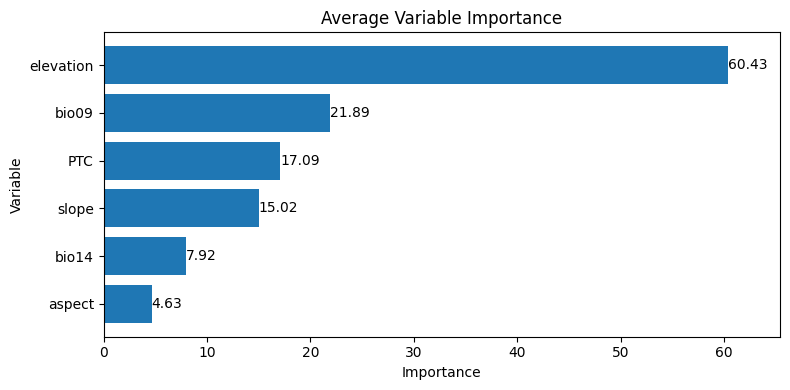

{'aspect': 4.629974584460849, 'bio14': 7.919448607565316, 'slope': 15.021046697496363, 'PTC': 17.092439903462527, 'bio09': 21.88775090104313, 'elevation': 60.42582508121201}


In [22]:
# Plot Average Variable Importance
eeSDM.plot_avg_variable_importance(results, numiter)

## 7. Predict with SDM Model

In [23]:
# Plot habitat suitability
images = ee.List.sequence(1, ee.Number(numiter).multiply(5).subtract(1), 5).map(lambda x: results.get(x))
ModelAverage = ee.ImageCollection.fromImages(images).mean()
Map = geemap.Map()
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['#440154', '#482677', '#404788', '#33638D', '#287D8E',
          '#1F968B', '#29AF7F', '#55C667', '#95D840', '#DCE319']}
Map = geemap.Map()
Map.addLayer(ModelAverage, vis_params, 'Habitat suitability')
Map.add_colorbar(vis_params, label="Habitat suitability", orientation="horizontal", layer_name="Habitat suitability")
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.4867782563472, 126.8854400655101], controls=(WidgetControl(options=['position', 'transparent_bg…

In [24]:
# Plot Potential distribution
images2 = ee.List.sequence(2, ee.Number(numiter).multiply(5).subtract(1), 5).map(lambda x: results.get(x))
DistributionMap = ee.ImageCollection.fromImages(images2).mode()

Map = geemap.Map()
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']}
Map.addLayer(DistributionMap, vis_params, 'Potential distribution')
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.add_colorbar(vis_params, label="Potential distribution", discrete=True, orientation="horizontal", layer_name="Potential distribution")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.4867782563472, 126.8854400655101], controls=(WidgetControl(options=['position', 'transparent_bg…

## 8. Accuracy Assessment

In [25]:
# Testing datasets
TestingDatasets = (ee.List.sequence(4, ee.Number(numiter).multiply(5).subtract(1), 5).map(lambda x: results.get(x)))

# Checking if there are sufficient presence and pseudo-absence points
eeSDM.print_pres_abs_sizes(TestingDatasets, numiter)

Iteration 1: Presence Size = 22, Pseudo-absence Size = 22
Iteration 2: Presence Size = 48, Pseudo-absence Size = 42
Iteration 3: Presence Size = 25, Pseudo-absence Size = 10
Iteration 4: Presence Size = 33, Pseudo-absence Size = 20
Iteration 5: Presence Size = 25, Pseudo-absence Size = 18
Iteration 6: Presence Size = 39, Pseudo-absence Size = 8
Iteration 7: Presence Size = 46, Pseudo-absence Size = 20
Iteration 8: Presence Size = 16, Pseudo-absence Size = 16
Iteration 9: Presence Size = 15, Pseudo-absence Size = 15
Iteration 10: Presence Size = 35, Pseudo-absence Size = 19


In [26]:
%%time

# Calculate AUC-ROC and AUC-PR
eeSDM.calculate_and_print_auc_metrics(images, TestingDatasets, GrainSize, numiter)

               AUC-ROC    AUC-PR
Iteration 1   0.812121  0.706777
Iteration 2   0.900298  0.883294
Iteration 3   0.960000  0.953685
Iteration 4   0.863333  0.868927
Iteration 5   0.839506  0.853763
Iteration 6   0.742647  0.842275
Iteration 7   0.823684  0.899499
Iteration 8   0.908482  0.891626
Iteration 9   0.677778  0.617214
Iteration 10  0.776316  0.757208
Mean AUC-ROC = 0.8304 ± 0.0838
Mean AUC-PR = 0.8274 ± 0.1026
CPU times: total: 156 ms
Wall time: 2min 39s


In [27]:
%%time

# Calculate Sensitivity and Specificity
eeSDM.calculate_and_print_ss_metrics(images, TestingDatasets, GrainSize, numiter)

              Sensitivity  Specificity
Iteration 1      0.666667     0.863636
Iteration 2      0.900000     0.833333
Iteration 3      1.000000     0.800000
Iteration 4      0.700000     0.900000
Iteration 5      0.833333     0.833333
Iteration 6      0.500000     0.875000
Iteration 7      0.700000     0.842105
Iteration 8      0.785714     1.000000
Iteration 9      0.583333     0.866667
Iteration 10     0.666667     0.842105
Mean Sensitivity = 0.7336 ± 0.1490
Mean Specificity = 0.8656 ± 0.0546
CPU times: total: 172 ms
Wall time: 2min 15s


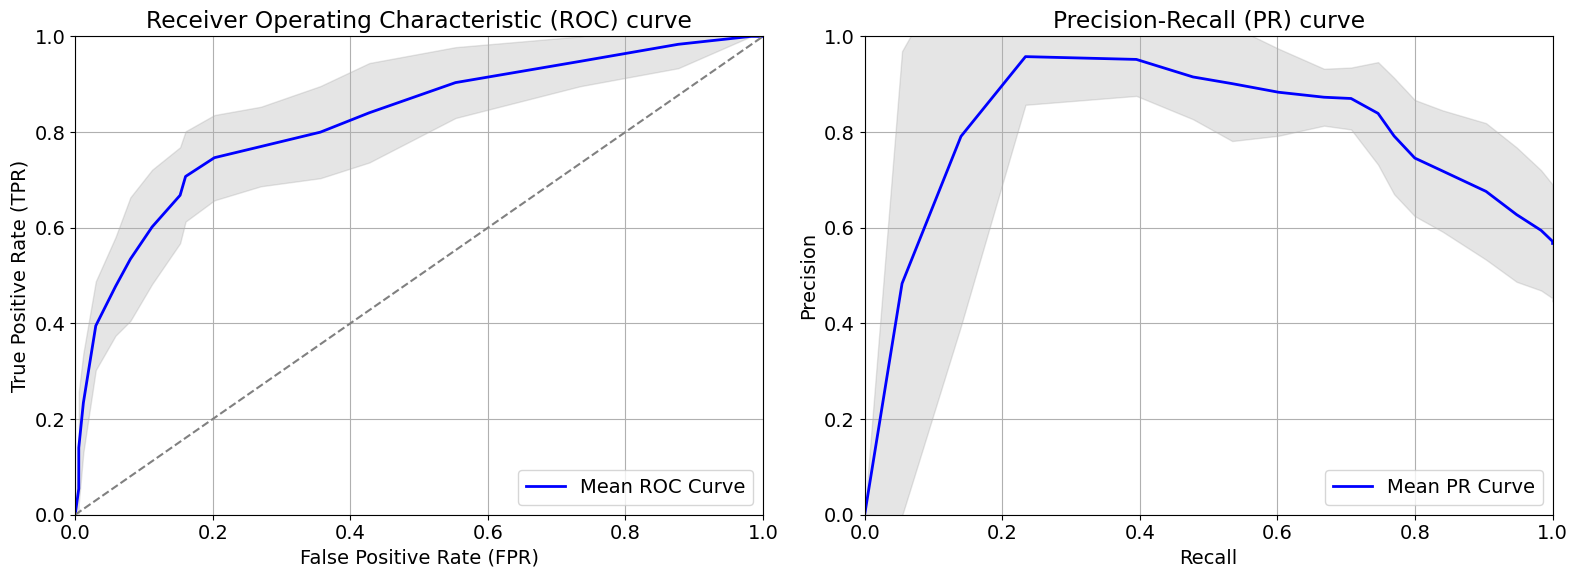

CPU times: total: 625 ms
Wall time: 2min 44s


In [28]:
%%time

# Plot ROC and PR curves
eeSDM.plot_roc_pr_curves(images, TestingDatasets, GrainSize, numiter)

In [29]:
%%time

# Potential Distribution Map using the optimal threshold
DistributionMap2 = eeSDM.create_DistributionMap2(images, TestingDatasets, GrainSize, numiter, ModelAverage)

Mean threshold: 0.47916666666666663
CPU times: total: 156 ms
Wall time: 2min 50s


In [30]:
out_dir = 'D:/GEODATA'

# Save Habitat Suitability Map as GeoTIFF
out_file = os.path.join(out_dir, 'habitat_suitability.tif')
geemap.ee_export_image(ModelAverage, filename=out_file, region=AOI, scale=1000)

# Save Potential Distribution Map as GeoTIFF
out_file = os.path.join(out_dir, 'distribution_map.tif')
geemap.ee_export_image(DistributionMap, filename=out_file, region=AOI, scale=1000)

# Save Potential Distribution Map with Optimal Threshold as GeoTIFF
out_file = os.path.join(out_dir, 'distribution_map2.tif')
geemap.ee_export_image(DistributionMap2, filename=out_file, region=AOI, scale=1000)

Generating URL ...
Please wait ...
Data downloaded to D:\GEODATA\habitat_suitability.tif
Generating URL ...
Please wait ...
Data downloaded to D:\GEODATA\distribution_map.tif
Generating URL ...
Please wait ...
Data downloaded to D:\GEODATA\distribution_map2.tif
